<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/05-ensamble%2Bsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de votación (LR+SS3+TFIDF) + SVM

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con todas las estrategias + la construcción de un clasificador con SVM.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 0. Configuración de la ejecución

A continuación se genera la configuración de las estrategias que integrarán el sistema de votación para la obtención de instancias:

In [1]:
# Posibilidades : lr, ss3, tfidf
# Combinaciones:
# lr-ss3
# lr-tfidf
# ss3-tfidf
# lr-ss3-tfidf

estrategias_feature_extraction = ['lr', 'ss3', 'tfidf']
ACUMULTATIVO = True

Se definen algunas características fijas:

In [2]:
# El archivo de test y el train con etiquetado manual es siempre el mismo
TEST_FILE = 'correos-test-jaiio-20.csv'
TRAIN_FILE_MANUAL = 'correos-train-jaiio-80.csv'
atributos_df = ['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
                  'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
                  'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
                  'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
                  'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
                  'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
                  'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score', 'clase_e0', 'clase_e1']

Y se generan los datos en función de la cantidad de estrategias a utilizar:

In [3]:
# Se genera el nombre del archivo de instancias a ejecutar en función de las estrategias
TRAIN_FILE_E0 = f'dataset-{estrategias_feature_extraction[0]}-200-prep.csv'
TRAIN_FILE_E1 = f'dataset-{estrategias_feature_extraction[1]}-200-prep.csv'
texto = f'Los dataset a utilizar son: \n\t{TRAIN_FILE_E0} \n\t{TRAIN_FILE_E1}'

# En caso que se realice el ensamble entre las 3 estrategias
if len(estrategias_feature_extraction)==3:
  TRAIN_FILE_E2 = f'dataset-{estrategias_feature_extraction[2]}-200-prep.csv'
  texto = texto + f'\n\t{TRAIN_FILE_E2}'
  # Se define el if para que ante reiteradas ejecuciones de la notebook no se vuelva a insertar
  if 'clase_e2' not in atributos_df:
    atributos_df.append('clase_e2')

print(texto)

Los dataset a utilizar son: 
	dataset-lr-200-prep.csv 
	dataset-ss3-200-prep.csv
	dataset-tfidf-200-prep.csv


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [4]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [6]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.3. Carga de datos

Cargo la librería warnings para no mostrar las advertencias y os para verificar la existencia de los archivos en la carga de datos. Además, cargo en memoria una lista de las etiquetas de las distintas clases:

In [7]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'

# Defino las clases y la cantidad a utilizar
etiquetas = get_clases()
CANTIDAD_CLASES = len(etiquetas)

Se cargan los dataframes de las estrategias seleccionadas en memoria con el preprocesamiento de los datos:

In [8]:
# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE_E0))

df_e0, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E0, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
df_e0['consulta'] = pd.Series(preprocesar_correos(df_e0['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))
# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(df_e0.clase.unique()), df_e0.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


In [9]:
# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE_E1))

df_e1, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E1, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
df_e1['consulta'] = pd.Series(preprocesar_correos(df_e1['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(df_e1.clase.unique()), df_e1.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Solo en el caso que decida hacer el sistema de votación entre las 3 estrategias inicializo la tercera:

In [10]:
if len(estrategias_feature_extraction)==3:

  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_E2))

  df_e2, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_E2, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  import pandas as pd
  df_e2['consulta'] = pd.Series(preprocesar_correos(df_e2['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(df_e2.clase.unique()), df_e2.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (3200, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Verifico si voy a acumular los datos etiquetados manualmente a los de etiquetado no supervisado y en caso afirmativo los cargo en memoria:

In [11]:
if ACUMULTATIVO:
 
  # Chequeo sobre si los archivos están en el working directory
  download_files = not(path.exists(TRAIN_FILE_MANUAL))

  train_df_manual, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_MANUAL, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

  # Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
  import pandas as pd
  train_df_manual['consulta'] = pd.Series(preprocesar_correos(train_df_manual['consulta']))

  # Muestro salida por consola
  print('Existen {} clases: {}.'.format(len(train_df_manual.clase.unique()), train_df_manual.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


Joineo mediante el texto de la consulta las estrategias encaradas (según sean dos o tres):

In [12]:
import pandas as pd

df_join = pd.merge(df_e0, df_e1, on='consulta', how='left')

# Si están las 3 estrategias, se incorpora también la 3era
if len(estrategias_feature_extraction)==3:
  df_join = pd.merge(df_join, df_e2, on='consulta', how='left')

Borro las instancias con faltantes y verifico el resultado la dimensionalidad del df:

In [13]:
df_join = df_join.dropna()

df_join.shape

(2357, 73)

Muestro las primeras 5 instancias:

In [14]:
df_join.head()

,consulta,dia_semana_x,semana_del_mes_x,mes_x,cuatrimestre_x,anio_x,hora_discretizada_x,dni_discretizado_x,legajo_discretizado_x,posee_legajo_x,posee_telefono_x,carrera_valor_x,proveedor_correo_x,cantidad_caracteres_x,proporcion_mayusculas_x,proporcion_letras_x,cantidad_tildes_x,cantidad_palabras_x,cantidad_palabras_cortas_x,proporcion_palabras_distintas_x,frecuencia_signos_puntuacion_x,cantidad_oraciones_x,utiliza_codigo_asignatura_x,score_x,clase_x,dia_semana_y,semana_del_mes_y,mes_y,cuatrimestre_y,anio_y,hora_discretizada_y,dni_discretizado_y,legajo_discretizado_y,posee_legajo_y,posee_telefono_y,carrera_valor_y,proveedor_correo_y,cantidad_caracteres_y,proporcion_mayusculas_y,proporcion_letras_y,cantidad_tildes_y,cantidad_palabras_y,cantidad_palabras_cortas_y,proporcion_palabras_distintas_y,frecuencia_signos_puntuacion_y,cantidad_oraciones_y,utiliza_codigo_asignatura_y,score_y,clase_y,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,score,clase
12,buenas tardes queria saber dice error credenci...,0,1,3,1,2018,0,6,3,1,1,3,18,239,0.0,0.807531,0,43,22,0.837209,0.012552,1,0,21.080560,Boleto Universitario,0.0,1.0,3.0,1.0,2018.0,0.0,6.0,3.0,1.0,1.0,3.0,22.0,239.0,0.0,0.807531,0.0,43.0,22.0,0.837209,0.012552,1.0,0.0,34.589447,Boleto Universitario,0.0,1.0,3.0,1.0,2018.0,0.0,6.0,3.0,1.0,1.0,3.0,23.0,239.0,0.0,0.807531,0.0,43.0,22.0,0.837209,0.012552,1.0,0.0,29.039064,Boleto Universitario
13,buen dia queria tramitar beneficio boleto estu...,0,1,3,1,2018,1,2,4,1,0,54,18,193,0.0,0.829016,3,29,12,0.931034,0.025907,4,0,20.477945,Boleto Universitario,0.0,1.0,3.0,1.0,2018.0,1.0,2.0,4.0,1.0,0.0,54.0,22.0,193.0,0.0,0.829016,3.0,29.0,12.0,0.931034,0.025907,4.0,0.0,27.813290,Boleto Universitario,0.0,1.0,3.0,1.0,2018.0,1.0,2.0,4.0,1.0,0.0,54.0,23.0,193.0,0.0,0.829016,3.0,29.0,12.0,0.931034,0.025907,4.0,0.0,21.707151,Boleto Universitario
22,hola hice hace mes tramite online boleto estud...,4,1,5,1,2019,1,8,4,1,1,3,9,237,0.0,0.797468,1,43,25,0.837209,0.021097,2,0,18.207250,Boleto Universitario,4.0,1.0,5.0,1.0,2019.0,1.0,8.0,4.0,1.0,1.0,3.0,11.0,237.0,0.0,0.797468,1.0,43.0,25.0,0.837209,0.021097,2.0,0.0,29.791120,Boleto Universitario,4.0,1.0,5.0,1.0,2019.0,1.0,8.0,4.0,1.0,1.0,3.0,13.0,237.0,0.0,0.797468,1.0,43.0,25.0,0.837209,0.021097,2.0,0.0,37.415314,Boleto Universitario
29,hola tal quisiera saber cargan beneficio bolet...,0,5,7,1,2017,2,5,4,1,1,54,9,166,0.0,0.813253,1,30,19,0.900000,0.012048,1,0,16.745590,Boleto Universitario,0.0,5.0,7.0,1.0,2017.0,2.0,5.0,4.0,1.0,1.0,54.0,11.0,166.0,0.0,0.813253,1.0,30.0,19.0,0.900000,0.012048,1.0,0.0,23.937635,Boleto Universitario,0.0,5.0,7.0,1.0,2017.0,2.0,5.0,4.0,1.0,1.0,54.0,13.0,166.0,0.0,0.813253,1.0,30.0,19.0,0.900000,0.012048,1.0,0.0,23.693140,Boleto Universitario
30,hace menos mes hice tramite boleto estudiantil...,4,4,8,2,2018,1,5,2,1,1,0,18,253,0.0,0.798419,1,48,28,0.854167,0.015810,1,0,16.336060,Boleto Universitario,4.0,4.0,8.0,2.0,2018.0,1.0,5.0,3.0,1.0,1.0,0.0,22.0,253.0,0.0,0.798419,1.0,48.0,28.0,0.854167,0.015810,1.0,0.0,26.332977,Boleto Universitario,4.0,4.0,8.0,2.0,2018.0,1.0,5.0,3.0,1.0,1.0,0.0,23.0,253.0,0.0,0.798419,1.0,48.0,28.0,0.854167,0.015810,1.0,0.0,30.765615,Boleto Universitario


Renombro las clases en función de las estrategias:

In [15]:
if len(estrategias_feature_extraction)==3:
  df_join.rename(columns={'clase_x': 'clase_e0', 'clase_y': 'clase_e1', 'clase': 'clase_e2'}, inplace=True)
else:
  df_join.rename(columns={'clase_x': 'clase_e0', 'clase': 'clase_e2'}, inplace=True)

print(df_join.columns)

Index(['consulta', 'dia_semana_x', 'semana_del_mes_x', 'mes_x',
       'cuatrimestre_x', 'anio_x', 'hora_discretizada_x', 'dni_discretizado_x',
       'legajo_discretizado_x', 'posee_legajo_x', 'posee_telefono_x',
       'carrera_valor_x', 'proveedor_correo_x', 'cantidad_caracteres_x',
       'proporcion_mayusculas_x', 'proporcion_letras_x', 'cantidad_tildes_x',
       'cantidad_palabras_x', 'cantidad_palabras_cortas_x',
       'proporcion_palabras_distintas_x', 'frecuencia_signos_puntuacion_x',
       'cantidad_oraciones_x', 'utiliza_codigo_asignatura_x', 'score_x',
       'clase_e0', 'dia_semana_y', 'semana_del_mes_y', 'mes_y',
       'cuatrimestre_y', 'anio_y', 'hora_discretizada_y', 'dni_discretizado_y',
       'legajo_discretizado_y', 'posee_legajo_y', 'posee_telefono_y',
       'carrera_valor_y', 'proveedor_correo_y', 'cantidad_caracteres_y',
       'proporcion_mayusculas_y', 'proporcion_letras_y', 'cantidad_tildes_y',
       'cantidad_palabras_y', 'cantidad_palabras_cortas_y',
 

Me quedo solo con los atributos que me interesan (elimino duplicados):

In [16]:
df_join = df_join[atributos_df]

df_join.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,score,clase_e0,clase_e1,clase_e2
12,buenas tardes queria saber dice error credenci...,0.0,1.0,3.0,1.0,2018.0,0.0,6.0,3.0,1.0,1.0,3.0,23.0,239.0,0.0,0.807531,0.0,43.0,22.0,0.837209,0.012552,1.0,0.0,29.039064,Boleto Universitario,Boleto Universitario,Boleto Universitario
13,buen dia queria tramitar beneficio boleto estu...,0.0,1.0,3.0,1.0,2018.0,1.0,2.0,4.0,1.0,0.0,54.0,23.0,193.0,0.0,0.829016,3.0,29.0,12.0,0.931034,0.025907,4.0,0.0,21.707151,Boleto Universitario,Boleto Universitario,Boleto Universitario
22,hola hice hace mes tramite online boleto estud...,4.0,1.0,5.0,1.0,2019.0,1.0,8.0,4.0,1.0,1.0,3.0,13.0,237.0,0.0,0.797468,1.0,43.0,25.0,0.837209,0.021097,2.0,0.0,37.415314,Boleto Universitario,Boleto Universitario,Boleto Universitario
29,hola tal quisiera saber cargan beneficio bolet...,0.0,5.0,7.0,1.0,2017.0,2.0,5.0,4.0,1.0,1.0,54.0,13.0,166.0,0.0,0.813253,1.0,30.0,19.0,0.900000,0.012048,1.0,0.0,23.693140,Boleto Universitario,Boleto Universitario,Boleto Universitario
30,hace menos mes hice tramite boleto estudiantil...,4.0,4.0,8.0,2.0,2018.0,1.0,5.0,3.0,1.0,1.0,0.0,23.0,253.0,0.0,0.798419,1.0,48.0,28.0,0.854167,0.015810,1.0,0.0,30.765615,Boleto Universitario,Boleto Universitario,Boleto Universitario


In [17]:
if len(estrategias_feature_extraction)==3:
  df_join['match_clase'] = ((df_join['clase_e0'] == df_join['clase_e1']) & (df_join['clase_e1'] == df_join['clase_e2']))
else:
  df_join['match_clase'] = df_join['clase_e0'] == df_join['clase_e1']  

In [18]:
train_df_join = df_join.query('match_clase == True').reset_index()

train_df_join.shape

(993, 29)

In [19]:
train_df_join.head()

,index,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,score,clase_e0,clase_e1,clase_e2,match_clase
0,12,buenas tardes queria saber dice error credenci...,0.0,1.0,3.0,1.0,2018.0,0.0,6.0,3.0,1.0,1.0,3.0,23.0,239.0,0.0,0.807531,0.0,43.0,22.0,0.837209,0.012552,1.0,0.0,29.039064,Boleto Universitario,Boleto Universitario,Boleto Universitario,True
1,13,buen dia queria tramitar beneficio boleto estu...,0.0,1.0,3.0,1.0,2018.0,1.0,2.0,4.0,1.0,0.0,54.0,23.0,193.0,0.0,0.829016,3.0,29.0,12.0,0.931034,0.025907,4.0,0.0,21.707151,Boleto Universitario,Boleto Universitario,Boleto Universitario,True
2,22,hola hice hace mes tramite online boleto estud...,4.0,1.0,5.0,1.0,2019.0,1.0,8.0,4.0,1.0,1.0,3.0,13.0,237.0,0.0,0.797468,1.0,43.0,25.0,0.837209,0.021097,2.0,0.0,37.415314,Boleto Universitario,Boleto Universitario,Boleto Universitario,True
3,29,hola tal quisiera saber cargan beneficio bolet...,0.0,5.0,7.0,1.0,2017.0,2.0,5.0,4.0,1.0,1.0,54.0,13.0,166.0,0.0,0.813253,1.0,30.0,19.0,0.900000,0.012048,1.0,0.0,23.693140,Boleto Universitario,Boleto Universitario,Boleto Universitario,True
4,30,hace menos mes hice tramite boleto estudiantil...,4.0,4.0,8.0,2.0,2018.0,1.0,5.0,3.0,1.0,1.0,0.0,23.0,253.0,0.0,0.798419,1.0,48.0,28.0,0.854167,0.015810,1.0,0.0,30.765615,Boleto Universitario,Boleto Universitario,Boleto Universitario,True


In [20]:
# Tomo una clase al azar, dado que coinciden las 3
train_df_join.rename(columns={'clase_e0': 'clase'}, inplace=True)

# Elimino las columnas que no necesito
train_df_join.drop(['index', 'clase_e1', 'match_clase'], inplace=True, axis=1)
if len(estrategias_feature_extraction)==3:
  train_df_join.drop(['clase_e2'], inplace=True, axis=1)

train_df_join.shape

(993, 25)

Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [21]:
score = train_df_join['score']
train_df_join.drop('score', inplace=True, axis=1)

In [22]:
if ACUMULTATIVO:
  train_df = pd.concat([train_df_manual, train_df_join], axis=0).reset_index(drop=True)
else:
  train_df = train_df_join

Muestro el dataframe resultante:

In [23]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
train_df.head()

,consulta,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,clase
0,queria saber puedo acceder boleto estudiantil ...,6.0,2.0,3.0,1.0,2019.0,2.0,7.0,4.0,1.0,1.0,3.0,4.0,107.0,0.0,0.775701,3.0,21.0,12.0,0.952381,0.000000,1.0,0.0,Boleto Universitario
1,puedo reseterar clave acceso sistema web ayer ...,4.0,2.0,12.0,2.0,2015.0,0.0,2.0,1.0,1.0,1.0,5.0,6.0,419.0,0.0,0.809069,0.0,78.0,45.0,0.717949,0.007160,1.0,0.0,Problemas con la Clave
2,dice beneficio sube quiero saber situacion,1.0,2.0,4.0,1.0,2019.0,3.0,8.0,4.0,1.0,1.0,3.0,6.0,96.0,0.0,0.781250,1.0,22.0,15.0,0.863636,0.000000,1.0,0.0,Boleto Universitario
3,buenos dias queria consultar puedo anotar tall...,3.0,4.0,10.0,2.0,2018.0,1.0,4.0,2.0,1.0,1.0,3.0,6.0,410.0,0.0,0.819512,5.0,70.0,34.0,0.728571,0.012195,2.0,0.0,Cursadas
4,buenas tardes quiero volver estudiar facultad ...,2.0,1.0,2.0,1.0,2019.0,0.0,2.0,0.0,0.0,1.0,54.0,6.0,175.0,0.0,0.811429,1.0,32.0,16.0,0.875000,0.011429,1.0,0.0,Cambio de Carrera


## 2. SVM

### 2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [24]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### 2.2 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.2.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [25]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [26]:
NO_CORRIDA = False

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_svm, None, atr_consulta='consulta')

#### 2.2.2 Modelo generado

En función de los mejores hiperparámetros encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas (por un bug en la función ya solucionado):

In [27]:
# Mejores Parámetros según GridSearchCV:
# {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'estrategia': '3-4-NGRAM-CHARS', 
#  'accuracy': 0.81, 'precision': 0.5971321956813028, 'recall': 0.553190280233687, 'f1_score': 0.5639032258154839}
# Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.835, 'precision': 0.8428499293134182, 'recall': 0.835, 'f1_score': 0.8328323317634259}

params_svm = {'SVM__C': [10], 
              'SVM__gamma': [0.01],
              'SVM__class_weight': ['balanced'],
              'SVM__kernel': ['sigmoid'],
              'SVM__probability': [True]
              }
              
clf, X_test, y_test = gridsearch_por_estrategia_representacion(train_df, test_df, '3-4-NGRAM-CHARS', 'SVM', params_svm, None, atr_consulta='consulta')

Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.8min finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.835, 'precision': 0.8428499293134182, 'recall': 0.835, 'f1_score': 0.8328323317634259}
Accuracy Test-Set: 0.835
Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.835, 'precision': 0.8428499293134182, 'recall': 0.835, 'f1_score': 0.8328323317634259}


Se predicen las instancias de testeo:

In [ ]:
y_pred = clf.predict(X_test)

Además, se utiliza el método _predict\_proba_ para calcular la probabilidad asociada a la clasificación de cada instancia:

In [ ]:
import numpy as np

y_pred_proba = np.around(clf.predict_proba(X_test), 2)

y_max_proba = np.amax(y_pred_proba, 1)

In [ ]:
y_max_proba

array([0.99, 0.83, 0.26, 0.38, 0.81, 0.91, 0.38, 0.81, 0.57, 0.33, 0.93,
       0.57, 0.98, 0.76, 0.96, 0.68, 0.66, 0.97, 0.94, 0.56, 0.38, 0.7 ,
       0.99, 0.51, 0.78, 0.92, 0.27, 0.78, 0.87, 0.97, 0.6 , 0.9 , 0.91,
       0.98, 0.29, 0.53, 0.97, 0.93, 0.98, 0.84, 0.99, 0.57, 0.76, 0.49,
       0.96, 0.99, 0.35, 0.59, 0.94, 0.8 , 0.71, 0.22, 1.  , 0.99, 0.77,
       0.65, 0.97, 0.97, 0.97, 0.85, 0.78, 1.  , 1.  , 1.  , 0.71, 0.94,
       0.81, 0.53, 0.98, 0.5 , 0.6 , 1.  , 0.98, 0.57, 0.84, 0.49, 0.67,
       1.  , 0.63, 0.98, 0.59, 0.53, 0.94, 0.82, 0.93, 0.96, 0.56, 0.92,
       0.43, 0.93, 0.87, 0.73, 0.42, 0.74, 0.49, 0.55, 0.59, 0.99, 0.93,
       0.93, 0.98, 0.49, 0.33, 0.48, 0.99, 0.87, 0.41, 0.92, 0.99, 0.53,
       0.98, 0.87, 0.69, 0.41, 0.92, 0.96, 0.96, 0.96, 0.95, 0.52, 0.95,
       0.44, 0.78, 0.7 , 0.84, 0.95, 0.3 , 0.57, 0.92, 1.  , 0.97, 0.34,
       0.82, 0.97, 0.99, 0.53, 0.89, 0.89, 0.98, 0.22, 0.21, 0.44, 0.99,
       0.5 , 0.99, 0.98, 0.29, 0.51, 0.32, 0.64, 0.

Se genera un _dataframe_ con las clases observadas para _test_, las predicciones y las probabilidades asociadas para verificar si hay relación entre las proba y los errores:

In [ ]:
import pandas as pd

resultados = pd.concat([pd.Series(y_test), pd.Series(y_pred), pd.Series(y_max_proba)], axis=1)
resultados.columns = ['clase', 'prediccion', 'max_proba']
resultados['correcto'] = resultados['clase'] == resultados['prediccion']

Se calcula el _accuracy__ para las predicciones con una proba>0.5 y se obtiene una mejora sustancial:

In [ ]:
sum(resultados[resultados.max_proba>0.5]['correcto'])/resultados[resultados.max_proba>0.5]['correcto'].count()

0.8909090909090909

#### 2.2.3 Métricas de selección

##### 2.2.3.1. Matriz de confusión

A continuación, se calcula la matriz de confusión para cada clase para el recorte con proba>0.5 y para el modelo con la totalidad de instancias:

In [ ]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:", metrics.accuracy_score(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

Accuracy: 0.8909090909090909
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.98      0.99        48
                  Cambio de Carrera       0.50      1.00      0.67         1
                 Cambio de Comisión       1.00      1.00      1.00         2
         Consulta por Equivalencias       1.00      1.00      1.00         2
                Consulta por Legajo       0.50      0.50      0.50         2
Consulta sobre Título Universitario       1.00      1.00      1.00         1
                           Cursadas       0.81      0.87      0.84        15
                   Datos Personales       0.00      0.00      0.00         1
                           Exámenes       1.00      1.00      1.00         3
           Ingreso a la Universidad       0.91      0.78      0.84        27
             Pedido de Certificados       0.93      1.00      0.97        14
             Problemas con la Clave       0.95

In [ ]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.825
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.98      0.99        48
                  Cambio de Carrera       0.50      0.50      0.50         2
                 Cambio de Comisión       1.00      1.00      1.00         2
         Consulta por Equivalencias       1.00      1.00      1.00         3
                Consulta por Legajo       0.67      0.67      0.67         3
Consulta sobre Título Universitario       0.75      1.00      0.86         3
                           Cursadas       0.53      0.84      0.65        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.80      0.80      0.80         5
           Ingreso a la Universidad       0.93      0.79      0.85        33
             Pedido de Certificados       0.88      0.93      0.90        15
             Problemas con la Clave       0.95      0.83   

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[47,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 16,  0,  0,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0, 26,  1,  1,  1,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0, 19,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  6,  2,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  4,  0,  0,  0,  0,

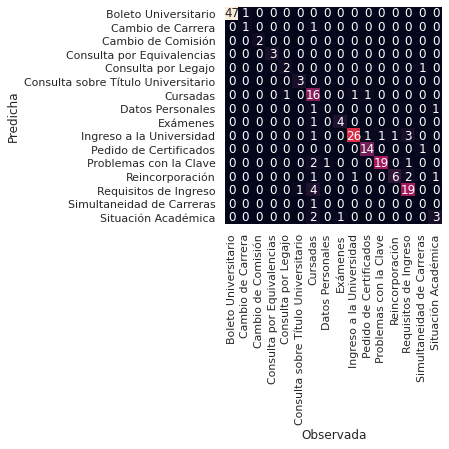

In [ ]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

A continuación se intenta entender la baja de _accuracy_ para el etiquetado a partir de TF-IDF.

Para ello, se genera el dataset de train con: <br/>
| consulta | clase | score |

In [ ]:
df_train_e = train_df[['consulta', 'clase']]
df_train_e['score'] = score

Genero un dataframe con los scores promedios por clase, el accuracy por clase y el _count_:

In [ ]:
df_error = df_train_e.groupby(['clase']).mean().reset_index()

# Accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count'] = mat.sum(axis=1)

df_error

,clase,score,accuracy,count
0,Boleto Universitario,22.352072,0.979167,48
1,Cambio de Carrera,22.814587,0.500000,2
2,Cambio de Comisión,23.643336,1.000000,2
3,Consulta por Equivalencias,21.676600,1.000000,3
4,Consulta por Legajo,22.457426,0.666667,3
5,Consulta sobre Título Universitario,23.823374,1.000000,3
6,Cursadas,21.978264,0.842105,19
7,Datos Personales,21.650824,0.000000,2
8,Exámenes,23.340097,0.800000,5
9,Ingreso a la Universidad,22.031455,0.787879,33


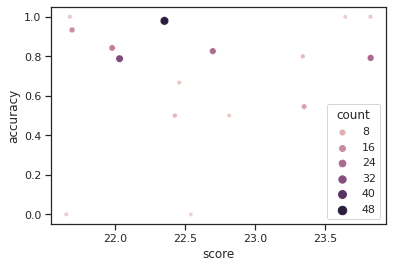

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.scatterplot(data=df_error, x="score", y="accuracy", hue="count", size="count")

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05